Braden Anderson and Hien Lam  
DS7333: Quantifying the World, Fall 2022
# <center> <u>Case Study 2</u>
Your case study is to build a classifier using logistic regression to predict hospital readmittance. There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from diabetes_case_study import *

In [2]:
diabetes = pd.read_csv('dataset_diabetes/diabetic_data.csv')
id_map = pd.read_csv('dataset_diabetes/IDs_mapping.csv')

# Preprocess
- `id_map` contains mapping to three columns in `diabetes` dataset: `admission_type_id`, `discharge_disposition_id`, `admission_source_id`. Will separate them into 3 dfs and join to diabetes df for eda purposes
- convert ? to nan
- drop column with 90% NAN
- drop columns with single values
- check if there are any duplicated columns
- decide imputation methods for necessary columns


In [3]:
pd.set_option('display.max_columns', None)
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
diabetes.shape

(101766, 50)

In [5]:
diabetes = diabetes.loc[diabetes["gender"] != 'Unknown/Invalid', :]

In [6]:
id_map.head(15)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


In [7]:
id_map.shape

(67, 2)

## Clean id_map and map to diabetes df

In [8]:
admission_type_id = id_map.iloc[0:9].rename(columns={"description" : "admission_type_desc"})
admission_type_id["admission_type_id"] = admission_type_id["admission_type_id"].astype(float)


discharge_disposition_id = id_map.iloc[10:41].rename(columns={"admission_type_id":"discharge_disposition_id",
                                                             "description" : "discharge_desc"})
discharge_disposition_id["discharge_disposition_id"] = discharge_disposition_id["discharge_disposition_id"].astype(float)


admission_source_id = id_map.iloc[42:67].rename(columns={"admission_type_id":"admission_source_id",
                                                        "description" : "admission_source_desc"})
admission_source_id["admission_source_id"] = admission_source_id["admission_source_id"].astype(float)

In [9]:
def get_code_map(df, code_col, desc_col):
    return {code:desc for code, desc in zip(df[code_col], df[desc_col])}

# Map admission type id to its description, creating new admission_type_desc column
admit_type_map = get_code_map(df=admission_type_id, 
                              code_col="admission_type_id", 
                              desc_col="admission_type_desc")
diabetes["admission_type_desc"] = [admit_type_map[code] for code in diabetes["admission_type_id"]]


# Map discharge dispo id to its description, creating new discharge_desc column
discharge_map = get_code_map(df=discharge_disposition_id, 
                             code_col="discharge_disposition_id", 
                             desc_col="discharge_desc")
diabetes["discharge_desc"] = [discharge_map[code] for code in diabetes["discharge_disposition_id"]]

# Map admission source id to its description, creating new admission_source_desc column
admit_source_map = get_code_map(df=admission_source_id, 
                                code_col="admission_source_id", 
                                desc_col="admission_source_desc")
diabetes["admission_source_desc"] = [admit_source_map[code] for code in diabetes["admission_source_id"]]

In [10]:
diabetes["admission_type_desc"] = diabetes["admission_type_desc"].fillna(value="Unknown")
diabetes["discharge_desc"] = diabetes["discharge_desc"].fillna(value="Unknown")
diabetes["admission_source_desc"] = diabetes["admission_source_desc"].fillna(value="Unknown")

for column in ["discharge_desc", "admission_type_desc", "admission_source_desc"]:
    print(f"Column: {column}, Number of NAs:{diabetes[column].isna().sum()}")

Column: discharge_desc, Number of NAs:0
Column: admission_type_desc, Number of NAs:0
Column: admission_source_desc, Number of NAs:0


In [11]:
#discharge_disposition_id
#diabetes.loc[diabetes["discharge_disposition_id"]==18,:]
#admission_source_id
#diabetes.loc[diabetes["admission_source_id"]==17,:].shape
#admission_type_id
#diabetes.loc[diabetes["admission_type_id"]==6,:].shape

In [12]:
id_desc_cols = ["admission_type_id", "admission_type_desc", 
                "discharge_disposition_id", "discharge_desc", 
                "admission_source_id", "admission_source_desc"]

diabetes.loc[:, id_desc_cols].head(10)

,admission_type_id,admission_type_desc,discharge_disposition_id,discharge_desc,admission_source_id,admission_source_desc
0,6,Unknown,25,Not Mapped,1,Physician Referral
1,1,Emergency,1,Discharged to home,7,Emergency Room
2,1,Emergency,1,Discharged to home,7,Emergency Room
3,1,Emergency,1,Discharged to home,7,Emergency Room
4,1,Emergency,1,Discharged to home,7,Emergency Room
5,2,Urgent,1,Discharged to home,2,Clinic Referral
6,3,Elective,1,Discharged to home,2,Clinic Referral
7,1,Emergency,1,Discharged to home,7,Emergency Room
8,2,Urgent,1,Discharged to home,4,Transfer from a hospital
9,3,Elective,3,Discharged/transferred to SNF,4,Transfer from a hospital


## NAs, single values, duplicates

In [13]:
# Figure out columns with missing values
missing_cols = [col for col in diabetes.columns if "?" in diabetes[col].unique().tolist()]
for col in missing_cols:
    diabetes.loc[diabetes[col]=="?", col] = np.nan

In [14]:
# Percentage of NA values. Drop `weight`
diabetes.isna().sum()[diabetes.isna().sum() > 0]/diabetes.shape[0]*100

race                  2.231656
weight               96.858387
payer_code           39.557600
medical_specialty    49.081690
diag_1                0.020636
diag_2                0.351798
diag_3                1.398347
dtype: float64

In [15]:
diabetes["age"] = diabetes["age"].map({"[0-10)":'Young', 
                                           "[10-20)":'Young', 
                                           "[20-30)":'Young', 
                                           "[30-40)":'Middle', 
                                           "[40-50)":'Middle', 
                                           "[50-60)":'Middle', 
                                           "[60-70)":'Old', 
                                           "[70-80)":'Old', 
                                           "[80-90)":'Old', 
                                           "[90-100)":'Old'})
diabetes.drop(columns="weight", inplace=True)

In [16]:
# Remove columns with single values
single_vals = diabetes.columns[diabetes.eq(diabetes.iloc[0]).all()].tolist()
print(f"There are {len(single_vals)} columns with single values: {single_vals}")
print(f"Original data dimiension: {diabetes.shape}")
diabetes.drop(columns=single_vals, inplace=True)
print(f"Final data dim after dropping aforementioned columns: {diabetes.shape}")
print(f"There are {diabetes.isna().sum().sum()} NA values and {diabetes.duplicated().sum()} duplicated records")

There are 2 columns with single values: ['examide', 'citoglipton']
Original data dimiension: (101763, 52)
Final data dim after dropping aforementioned columns: (101763, 50)
There are 94275 NA values and 0 duplicated records


## EDA

In [17]:
diabetes.dtypes.value_counts()

object    37
int64     13
dtype: int64

In [18]:
diabetes.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017630e+05,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,1.652008e+08,5.432965e+07,2.024017,3.715515,5.754459,4.396018,43.095909,1.339691,16.021835,0.369368,0.197842,0.635585,7.422649
std,1.026410e+08,3.869658e+07,1.445414,5.279919,4.064110,2.985092,19.674220,1.705792,8.127589,1.267282,0.930485,1.262877,1.933578
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.495975e+07,2.341296e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523883e+08,4.550049e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302698e+08,8.754571e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [19]:
diabetes.describe(exclude=np.number)

,race,gender,age,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc
count,99492,101763,101763,61508,51816,101742,101405,100340,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763,101763
unique,5,2,3,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,4,4,2,2,2,2,2,2,3,8,26,17
top,Caucasian,Female,Old,MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
freq,76099,54708,68538,32439,14635,6862,6752,11555,96417,84745,81776,100224,101060,101677,96572,101762,89078,91113,101740,94436,95399,101455,101725,101760,101724,47380,101057,101750,101762,101761,101762,54754,78361,54861,53988,60232,57492


In [20]:
diabetes.select_dtypes(include=object).head()

,race,gender,age,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc
0,Caucasian,Female,Young,NaN,Pediatrics-Endocrinology,250.83,NaN,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Unknown,Not Mapped,Physician Referral
1,Caucasian,Female,Young,NaN,NaN,276,250.01,255,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Young,NaN,NaN,648,250,V27,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,Caucasian,Male,Middle,NaN,NaN,8,250.43,403,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,Caucasian,Male,Middle,NaN,NaN,197,157,250,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [21]:
#cols = ["A1Cresult", "metformin", 'metformin-pioglitazone', "glipizide-metformin", "metformin-rosiglitazone"]
#diabetes.loc[:,cols]

In [22]:
# TODO: pipeline without encoder, plot after imputing

# numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
#                                    ('scaler', PowerTransformer(method="yeo-johnson"))])

# nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
#                                    ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])

# numeric_features = ["diag_1", "diag_2", "diag_3"]
# nominal_cat_feats = ["race", "payer_code", "medical_specialty"]

# preprocess = ColumnTransformer(transformers=[("numeric_feats", numeric_pipeline, selector(dtype_include=int)), 
#                                              ("nom_cat_feats", nominal_pipeline, selector(dtype_include=object))],
#                                remainder="passthrough",
#                                sparse_threshold=0.3)

In [23]:
# for i in diabetes.columns:
#     #fig, ax = plt.subplots(nrows=1, ncols=1, figsize(10, 20))
#     sns.displot(diabetes[i], kde=True)
#     plt.show()

In [24]:
diabetes["age"].nunique()

3

## Imputation

### `medical_speciality`
- 45% missing values
- categorical dtype
- imputation method: 

### `payer_code`
- 40% missing values
- categorical dtype
- imputation method: 

In [25]:
diabetes.payer_code.value_counts(normalize=True)

MC    0.527395
HM    0.102003
SP    0.081404
BC    0.075681
MD    0.057423
CP    0.041149
UN    0.039800
CM    0.031492
OG    0.016795
PO    0.009625
DM    0.008926
CH    0.002374
WC    0.002195
OT    0.001545
MP    0.001284
SI    0.000894
FR    0.000016
Name: payer_code, dtype: float64

In [26]:
# Fill missing payer code values with unknown
diabetes["payer_code"] = diabetes["payer_code"].fillna(value="Unknown")

### `race`
- 2% missing values
- categorical dtype
- imputation method: 

In [27]:
diabetes.race.value_counts(normalize=True)

Caucasian          0.764876
AfricanAmerican    0.193081
Hispanic           0.020474
Other              0.015127
Asian              0.006443
Name: race, dtype: float64

### `diag_3`
- Additional secondary diagnosis; 789 distinct values
- 1.4% missing values
- numerical dtype
- imputation method: 

In [28]:
diabetes.diag_3.nunique()

789

In [29]:
diabetes.diag_3.value_counts(normalize=True)

250     0.115158
401     0.082599
276     0.051575
428     0.045615
427     0.039416
          ...   
657     0.000010
684     0.000010
603     0.000010
E826    0.000010
971     0.000010
Name: diag_3, Length: 789, dtype: float64

### `diag_2`
- Secondary dignosis; 748 distinct values
- 0.35% missing values
- numerical dtype
- imputation method: 

In [30]:
diabetes.diag_2.nunique()

748

In [31]:
diabetes.diag_2.value_counts(normalize=True)

276     0.066584
428     0.065697
250     0.059869
427     0.049662
401     0.036842
          ...   
232     0.000010
908     0.000010
52      0.000010
E817    0.000010
927     0.000010
Name: diag_2, Length: 748, dtype: float64

### `diag_1`
- The primary diagnosis; 716 distinct values
- 0.02% missing values
- numerical dtype
- imputation method: 

Map diag_1 column values per Table 2 of Impact of HbA1c Measurement on Hospital Readmission Rates:
Analysis of 70,000 Clinical Database Patient Records

In [32]:
def combine_dicts(*args):
    combined = {}
    for d in args:
        for k, v in d.items():
            combined[k]=v
    return combined

m1 = {str(num):"Circulatory" for num in list(range(390, 460)) + [785]}
m2 = {str(num):"Respiratory" for num in list(range(460, 520)) + [786]}
m3 = {str(num):"Digestive" for num in list(range(520, 580)) + [787]}
m4 = {str(num):"Diabetes" for num in [val for val in diabetes["diag_1"].unique().tolist() if str(val).startswith("250")]}
m5 = {str(num):"Injury" for num in range(800, 1_000)}
m6 = {str(num):"Musculoskeletal" for num in range(710, 740)}
m7 = {str(num):"Genitourinary" for num in list(range(580, 630)) + [788]}
m8 = {str(num):"Neoplasms" for num in list(range(140, 240)) + 
      [780, 781, 782, 784] + list(range(790, 800)) + [val for val in range(240, 280) if val != 250] + 
      list(range(680, 710)) + list(range(1, 140))}

combined_map = combine_dicts(m1,m2,m3,m4,m5,m6,m7,m8)
other_map = {val:"Other" for val in diabetes["diag_1"].to_numpy() if val not in combined_map.keys()}
full_map = combine_dicts(combined_map,other_map)
diabetes["diag_1"] = diabetes["diag_1"].map(full_map)

In [33]:
diabetes.diag_1.nunique()

9

In [34]:
diabetes.diag_1.value_counts(normalize=True)

Circulatory        0.299087
Respiratory        0.141731
Neoplasms          0.138125
Digestive          0.093108
Diabetes           0.086053
Other              0.074389
Injury             0.068512
Genitourinary      0.050284
Musculoskeletal    0.048711
Name: diag_1, dtype: float64

train_df# Modeling
- Scaler used:
- Imputation methods used:
- Summary stats after imputation

In [35]:
# plot_categorical_interactions(df=diabetes, 
#                               x_categorical="age", 
#                               interaction_categorical="num_procedures", 
#                               response_variable="readmitted", 
#                               response_success_level="NO", 
#                               conf_level=0.95, 
#                               figsize=(18, 6))


# plot_categorical_interactions(df=diabetes, 
#                               x_categorical="age", 
#                               interaction_categorical="diag_1", 
#                               response_variable="readmitted", 
#                               response_success_level="NO", 
#                               conf_level=0.95, 
#                               figsize=(18, 6))


# plot_categorical_interactions(df=model_df, 
#                               x_categorical="race", 
#                               interaction_categorical="gender", 
#                               response_variable="readmitted", 
#                               response_success_level="NO", 
#                               conf_level=0.95, 
#                               figsize=(18, 6))


# plot_categorical_proportions(df=model_df, 
#                               grouping_variable_list=["race", "gender"], response_variable="readmitted",
#                               response_success_level="NO")

In [36]:
model_df = diabetes.drop(columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id']).copy(deep=True)

keep_diag1 = model_df["diag_1"].value_counts(normalize=True).sort_values(ascending=True).index.to_numpy()[:10]
model_df.loc[~model_df["diag_1"].isin(keep_diag1),"diag_1"] = "Other"
model_df.drop(columns=["diag_2", "diag_3"], inplace=True)

columns_with_missings = model_df.isna().sum()[model_df.isna().sum() > 0].index.tolist()

model_df.loc[:,columns_with_missings]

,race,medical_specialty
0,Caucasian,Pediatrics-Endocrinology
1,Caucasian,NaN
2,AfricanAmerican,NaN
3,Caucasian,NaN
4,Caucasian,NaN
...,...,...
101761,AfricanAmerican,NaN
101762,AfricanAmerican,NaN
101763,Caucasian,NaN
101764,Caucasian,Surgery-General


### Models without interactions (OneVsRest --> "multinomial loss")

#### Numeric Preprocessing: Yeo-Johnson Power Transform

In [37]:
# train test split
# cross validation with training --> pick model
# with picked model, test 
train_df, test_df = train_test_split(model_df,
                                     test_size=0.05, 
                                     stratify=model_df["readmitted"],
                                     random_state=77)

In [38]:
X_train, y_train = train_df.drop(columns="readmitted"), train_df["readmitted"]
X_test, y_test = test_df.drop(columns="readmitted"), test_df["readmitted"]

In [39]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, selector(dtype_include=[int,float])), 
                                             ("cat", nominal_pipeline, selector(dtype_include=[object, "category"]))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

model = Pipeline(steps=[("preprocess", preprocess), 
                        ("logreg", LogisticRegression(random_state=77, 
                                                      solver="saga",
                                                      multi_class="multinomial", 
                                                      max_iter=10_000))])

In [40]:
## Baseline model
cv_results = cross_validate(estimator=model, 
                            X=X_train,
                            y=y_train, 
                            cv=StratifiedKFold(n_splits=5, 
                                               shuffle=True, 
                                               random_state=77), 
                            n_jobs=-1,
                            return_train_score=True, 
                            return_estimator=True,
                            scoring=["accuracy", 
                                     "f1_weighted", 
                                     "precision_weighted"], 
                            error_score="raise")

coef_df = pd.DataFrame({"feature":cv_results['estimator'][0][:-1].get_feature_names_out(),
                        "model1_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[0,:], 
                        "model2_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[1,:],
                        "model3_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[2,:]})

model1_coef_df = coef_df.reindex(coef_df["model1_coefs"].abs().sort_values(ascending=False).index)
model2_coef_df = coef_df.reindex(coef_df["model2_coefs"].abs().sort_values(ascending=False).index)
model3_coef_df = coef_df.reindex(coef_df["model3_coefs"].abs().sort_values(ascending=False).index)

print(f"Train Accuracy: {cv_results['train_accuracy']}")
print(f"Test Accuracy: {cv_results['test_accuracy']}")

Train Accuracy: [0.59514605 0.59482279 0.59629682 0.59633561 0.59608223]
Test Accuracy: [0.59622446 0.5960693  0.59239721 0.59229377 0.58860039]


In [41]:
cv_results['test_accuracy'].mean()

0.5931170271568977

In [42]:
#%%time

#Smaller value = Stronger Regularization
# reg_strength = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 
#                 1.1, 1.3, 1.5, 2.0, 2.5, 5.0, 10.0]

# parameter_grid = [{"logreg__penalty":["l1", "l2"], 
#                    "logreg__class_weight":['balanced', None],
#                    "logreg__C":reg_strength}, 
                  
#                   {"logreg__penalty":["elasticnet"], 
#                    "logreg__class_weight":["balanced", None], 
#                    "logreg__C":reg_strength, 
#                    "logreg__l1_ratio":[0.25, 0.5, 0.75]}]

# gs = run_gridsearch(X=X_train, 
#                     y=y_train, 
#                     estimator=model, 
#                     param_grid=parameter_grid, 
#                     save_name=get_gs_save_name(model_name="logreg"))

# gs_df = pd.DataFrame(gs.cv_results_)

g = load_gs_from_pickle(pickle_filepath="./models/logreg_20220916_1347_gs.pkl")
gs_df = pd.DataFrame(g.cv_results_)

In [43]:
g.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206A368850>),
                                                 ('cat',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206A368B80>)])),
                ('logreg',
                 LogisticRegression(C=0.7, max_iter=10000,
                                    multi_class='multinomial', random_state=77,
                                    solver='saga'))])

In [44]:
g.best_score_

0.5936135622941656

In [45]:
g.best_params_

{'logreg__C': 0.7, 'logreg__class_weight': None, 'logreg__penalty': 'l2'}

In [46]:
gs_df.sort_values(by="rank_test_accuracy").head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__l1_ratio,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_train_precision_weighted,split1_train_precision_weighted,split2_train_precision_weighted,split3_train_precision_weighted,split4_train_precision_weighted,mean_train_precision_weighted,std_train_precision_weighted
23,27.782754,1.649602,0.693601,0.038011,0.7,None,l2,NaN,"{'logreg__C': 0.7, 'logreg__class_weight': Non...",0.592345,0.594104,0.595656,0.594828,0.591135,0.593614,0.001652,1,0.596982,0.595909,0.594862,0.595017,0.596367,0.595827,0.000803,0.547469,0.549993,0.550231,0.549468,0.545229,0.548478,0.001893,22,0.552411,0.551155,0.549718,0.549768,0.551433,0.550897,0.001031,0.550433,0.557920,0.559997,0.555804,0.550466,0.554924,0.003887,80,0.562651,0.559012,0.556619,0.558087,0.559009,0.559076,0.001990
65,169.529355,47.529326,0.713547,0.037529,0.05,None,elasticnet,0.75,"{'logreg__C': 0.05, 'logreg__class_weight': No...",0.591466,0.594311,0.595811,0.596018,0.590462,0.593614,0.002264,2,0.595560,0.594189,0.593698,0.593310,0.595203,0.594392,0.000862,0.544399,0.547444,0.547847,0.548044,0.542521,0.546051,0.002206,73,0.548296,0.546803,0.545933,0.545632,0.547986,0.546930,0.001065,0.548282,0.558374,0.558929,0.549045,0.549475,0.552821,0.004779,148,0.557206,0.554012,0.552000,0.555966,0.557277,0.555292,0.002027


#### Numeric Preprocessing: Standard Scaler

In [47]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', StandardScaler())])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, selector(dtype_include=[int,float])), 
                                             ("cat", nominal_pipeline, selector(dtype_include=[object, "category"]))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

model_sc = Pipeline(steps=[("preprocess", preprocess), 
                           ("logreg", LogisticRegression(random_state=77, 
                                                         solver="saga",
                                                         multi_class="multinomial", 
                                                         max_iter=10_000))])

In [48]:
## Baseline model
cv_results_sc = cross_validate(estimator=model_sc, 
                               X=X_train,
                               y=y_train, 
                               cv=StratifiedKFold(n_splits=5, 
                                                  shuffle=True, 
                                                  random_state=77), 
                               n_jobs=-1,
                               return_train_score=True, 
                               return_estimator=True,
                               scoring=["accuracy", 
                                        "f1_weighted", 
                                        "precision_weighted"], 
                               error_score="raise")

coef_sc_df = pd.DataFrame({"feature":cv_results_sc['estimator'][0][:-1].get_feature_names_out(),
                        "model1_coefs":cv_results_sc['estimator'][0].named_steps["logreg"].coef_[0,:], 
                        "model2_coefs":cv_results_sc['estimator'][0].named_steps["logreg"].coef_[1,:],
                        "model3_coefs":cv_results_sc['estimator'][0].named_steps["logreg"].coef_[2,:]})

model1_sc_coef_df = coef_sc_df.reindex(coef_sc_df["model1_coefs"].abs().sort_values(ascending=False).index)
model2_sc_coef_df = coef_sc_df.reindex(coef_sc_df["model2_coefs"].abs().sort_values(ascending=False).index)
model3_sc_coef_df = coef_sc_df.reindex(coef_sc_df["model3_coefs"].abs().sort_values(ascending=False).index)

print(f"Train Accuracy: {cv_results_sc['train_accuracy']}")
print(f"Test Accuracy: {cv_results_sc['test_accuracy']}")

Train Accuracy: [0.594784   0.59349099 0.59608994 0.59567618 0.59640548]
Test Accuracy: [0.59244893 0.59824153 0.59229377 0.59250065 0.5895314 ]


In [49]:
cv_results_sc['test_accuracy'].mean()

0.5930032534925831

In [50]:
# #Smaller value = Stronger Regularization
# reg_strength = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 
#                 1.0, 1.1, 1.3, 1.5, 2.0, 2.5, 5.0, 10.0]

# parameter_grid = [{"logreg__penalty":["l1", "l2"], 
#                    "logreg__class_weight":['balanced', None],
#                    "logreg__C":reg_strength}, 
                  
#                   {"logreg__penalty":["elasticnet"], 
#                    "logreg__class_weight":["balanced", None], 
#                    "logreg__C":reg_strength, 
#                    "logreg__l1_ratio":[0.25, 0.5, 0.75]}]

# gs_sc = run_gridsearch(X=X_train, 
#                     y=y_train, 
#                     estimator=model_sc, 
#                     param_grid=parameter_grid, 
#                     save_name=get_gs_save_name(model_name="logreg_sc"))

# gs_sc_df = pd.DataFrame(gs_sc.cv_results_)

g_sc = load_gs_from_pickle(pickle_filepath="./models/logreg_sc_20220917_0013_gs.pkl")
gs_sc_df = pd.DataFrame(g_sc.cv_results_)

In [51]:
g_sc.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206A4395E0>),
                                                 ('cat',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206A4397F0>)])),
                ('logreg',
                 LogisticRegression(C=0.7, max_iter=10000,
                                    multi_class='multinomial', random_state=77,
                                    solver='saga'))])

In [52]:
g_sc.best_params_

{'logreg__C': 0.7, 'logreg__class_weight': None, 'logreg__penalty': 'l2'}

In [53]:
g_sc.best_score_

0.5932204959412731

In [54]:
gs_sc_df.sort_values(by="rank_test_accuracy").head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__l1_ratio,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_train_precision_weighted,split1_train_precision_weighted,split2_train_precision_weighted,split3_train_precision_weighted,split4_train_precision_weighted,mean_train_precision_weighted,std_train_precision_weighted
23,139.978377,5.977735,0.66080,0.018477,0.7,None,l2,NaN,"{'logreg__C': 0.7, 'logreg__class_weight': Non...",0.590225,0.593638,0.594673,0.596121,0.591445,0.593220,0.002136,1,0.596219,0.594939,0.594319,0.593995,0.595837,0.595062,0.000854,0.540506,0.545378,0.545130,0.546923,0.541811,0.54395,0.002396,22,0.547516,0.546160,0.545066,0.544398,0.546364,0.545901,0.001081,0.556753,0.560744,0.567847,0.564999,0.557582,0.561585,0.004265,85,0.567270,0.565793,0.562344,0.563693,0.567146,0.565249,0.001941
117,397.258581,13.726573,0.65531,0.011080,1.3,None,elasticnet,0.25,"{'logreg__C': 1.3, 'logreg__class_weight': Non...",0.590122,0.593587,0.594621,0.596121,0.591445,0.593179,0.002157,2,0.596297,0.595043,0.594383,0.594060,0.595914,0.595139,0.000859,0.540529,0.545539,0.545169,0.546932,0.541929,0.54402,0.002394,13,0.547655,0.546349,0.545216,0.544525,0.546525,0.546054,0.001087,0.556807,0.561343,0.567886,0.564370,0.557484,0.561578,0.004175,86,0.567433,0.565769,0.562889,0.563904,0.567472,0.565493,0.001847


### OneVsOne Models

In [55]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, selector(dtype_include=[int,float])), 
                                             ("cat", nominal_pipeline, selector(dtype_include=[object, "category"]))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

ovo_model = Pipeline(steps=[("preprocess", preprocess), 
                            ("ovo_logreg", OneVsRestClassifier(LogisticRegression(random_state=77,
                                                                                  solver="saga", 
                                                                                  max_iter=10_000)))])

In [56]:
## Baseline model with OVO strategy

cv_ovo_results = cross_validate(estimator=ovo_model, 
                                X=X_train,
                                y=y_train, 
                                cv=StratifiedKFold(n_splits=5, 
                                                   shuffle=True, 
                                                   random_state=77), 
                                n_jobs=-1,
                                return_train_score=True, 
                                return_estimator=True,
                                scoring=["accuracy", 
                                         "f1_weighted", 
                                         "precision_weighted"], 
                                error_score="raise")


print(f"Train Accuracy: {cv_ovo_results['train_accuracy']}")
print(f"Test Accuracy: {cv_ovo_results['test_accuracy']}")

Train Accuracy: [0.59493916 0.59451247 0.59580548 0.59561153 0.59603051]
Test Accuracy: [0.59565555 0.59565555 0.59374192 0.59193173 0.58797972]


In [57]:
cv_ovo_results['train_accuracy'].mean()

0.5953798315713558

In [58]:
coef_ovo_df = pd.DataFrame({"feature":cv_ovo_results['estimator'][0][:-1].get_feature_names_out(),
                            "model1_coefs":cv_ovo_results['estimator'][0].named_steps["ovo_logreg"].estimators_[0].coef_.ravel(), 
                            "model2_coefs":cv_ovo_results['estimator'][0].named_steps["ovo_logreg"].estimators_[1].coef_.ravel(),
                            "model3_coefs":cv_ovo_results['estimator'][0].named_steps["ovo_logreg"].estimators_[2].coef_.ravel()})

model1_ovo_coef_df = coef_ovo_df.reindex(coef_ovo_df["model1_coefs"].abs().sort_values(ascending=False).index)
model2_ovo_coef_df = coef_ovo_df.reindex(coef_ovo_df["model2_coefs"].abs().sort_values(ascending=False).index)
model3_ovo_coef_df = coef_ovo_df.reindex(coef_ovo_df["model3_coefs"].abs().sort_values(ascending=False).index)

### Models with interactions

In [59]:
poly_features = ["num_procedures", "num_medications", "number_inpatient", "time_in_hospital", 
                 "number_diagnoses", "number_outpatient", "number_emergency"]

model_poly_df = create_polynomial_df(df=model_df, poly_features=poly_features)

In [60]:
train_poly_df, test_poly_df = train_test_split(model_poly_df,
                                               test_size=0.05, 
                                               stratify=model_poly_df["readmitted"],
                                               random_state=77)

In [61]:
X_train_poly, y_train_poly = train_poly_df.drop(columns="readmitted"), train_poly_df["readmitted"]
X_test_poly, y_test_poly = test_poly_df.drop(columns="readmitted"), test_poly_df["readmitted"]

In [62]:
numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, selector(dtype_include=[int,float])), 
                                             ("cat", nominal_pipeline, selector(dtype_include=[object, "category"]))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

poly_model = Pipeline(steps=[("preprocess", preprocess), 
                             ("logreg", LogisticRegression(random_state=77, 
                                                           solver="saga",
                                                           multi_class="multinomial", 
                                                           max_iter=10_000))])

In [63]:
## Baseline model, polynomial terms added
cv_poly_results = cross_validate(estimator=poly_model, 
                                 X=X_train_poly,
                                 y=y_train_poly, 
                                 cv=StratifiedKFold(n_splits=5, 
                                                    shuffle=True, 
                                                    random_state=77), 
                                 return_train_score=True, 
                                 return_estimator=True,
                                 scoring=["accuracy", 
                                          "f1_weighted", 
                                          "precision_weighted"], 
                                 error_score="raise")

coef_poly_df = pd.DataFrame({"feature":cv_poly_results['estimator'][0][:-1].get_feature_names_out(),
                             "model1_coefs":cv_poly_results['estimator'][0].named_steps["logreg"].coef_[0,:], 
                             "model2_coefs":cv_poly_results['estimator'][0].named_steps["logreg"].coef_[1,:],
                             "model3_coefs":cv_poly_results['estimator'][0].named_steps["logreg"].coef_[2,:]})

model1_poly_coef_df = coef_poly_df.reindex(coef_poly_df["model1_coefs"].abs().sort_values(ascending=False).index)
model2_poly_coef_df = coef_poly_df.reindex(coef_poly_df["model2_coefs"].abs().sort_values(ascending=False).index)
model3_poly_coef_df = coef_poly_df.reindex(coef_poly_df["model3_coefs"].abs().sort_values(ascending=False).index)

print(f"Train Accuracy: {cv_poly_results['train_accuracy']}")
print(f"Test Accuracy: {cv_poly_results['test_accuracy']}")

Train Accuracy: [0.59752518 0.59607701 0.59743467 0.59831392 0.59868115]
Test Accuracy: [0.59534523 0.59829325 0.59550039 0.59405224 0.59010034]


In [64]:
cv_poly_results['test_accuracy'].mean()

0.5946582891165386

In [65]:
#%%time

# Smaller value = Stronger Regularization
# reg_strength = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 2.0, 2.5, 5.0, 10.0]

# parameter_grid = [{"logreg__penalty":["l1", "l2"], 
#                    "logreg__class_weight":['balanced', None],
#                    "logreg__C":reg_strength}, 
                  
#                   {"logreg__penalty":["elasticnet"], 
#                    "logreg__class_weight":["balanced", None], 
#                    "logreg__C":reg_strength, 
#                    "logreg__l1_ratio":[0.25, 0.5, 0.75]}]

# gs_poly = run_gridsearch(X=X_train_poly, 
#                          y=y_train_poly, 
#                          estimator=poly_model, 
#                          param_grid=parameter_grid, 
#                          save_name=get_gs_save_name(model_name="logreg"))

#gs_df = pd.DataFrame(gs.cv_results_)

g_poly = load_gs_from_pickle(pickle_filepath="./models/logreg_20220915_2253_gs.pkl")
gs_poly_df = pd.DataFrame(g_poly.cv_results_)

In [66]:
g_poly.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206D020EE0>),
                                                 ('cat',
                                                  Pipeline(steps=[('nom_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001206CFBBF10>)])),
                ('logreg',
                 LogisticRegression(C=0.9, max_iter=10000,
                                    multi_class='multinomial', random_state=77,
                                    solver='saga'))])

In [67]:
g_poly.best_score_

0.5951651713997503

In [68]:
g_poly.best_params_

{'logreg__C': 0.9, 'logreg__class_weight': None, 'logreg__penalty': 'l2'}

In [69]:
gs_poly_df.sort_values(by="rank_test_accuracy").head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__l1_ratio,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_train_precision_weighted,split1_train_precision_weighted,split2_train_precision_weighted,split3_train_precision_weighted,split4_train_precision_weighted,mean_train_precision_weighted,std_train_precision_weighted
27,61.716227,3.633332,0.798133,0.121037,0.9,None,l2,NaN,"{'logreg__C': 0.9, 'logreg__class_weight': Non...",0.591363,0.596587,0.596845,0.598086,0.592945,0.595165,0.002560,1,0.598779,0.597241,0.596788,0.596310,0.598254,0.597474,0.000916,0.547773,0.553226,0.551918,0.553812,0.548460,0.551038,0.002472,18,0.555100,0.553339,0.552388,0.552159,0.554194,0.553436,0.001103,0.553413,0.565781,0.562523,0.558479,0.553204,0.55868,0.004959,78,0.565225,0.561941,0.560736,0.562527,0.563891,0.562864,0.001557
137,361.351254,25.818020,0.700024,0.005209,2.5,None,elasticnet,0.75,"{'logreg__C': 2.5, 'logreg__class_weight': Non...",0.590949,0.596638,0.596949,0.597983,0.593255,0.595155,0.002635,2,0.598650,0.597280,0.596866,0.596284,0.598229,0.597462,0.000869,0.547365,0.553535,0.552198,0.553752,0.548827,0.551135,0.002580,7,0.555072,0.553399,0.552592,0.552251,0.554261,0.553515,0.001044,0.552093,0.566376,0.563911,0.557067,0.553855,0.55866,0.005583,79,0.565245,0.562055,0.561482,0.562837,0.564515,0.563227,0.001436


# Feature Importance

### Gridsearch, OneVsRest, yeo-johnson 

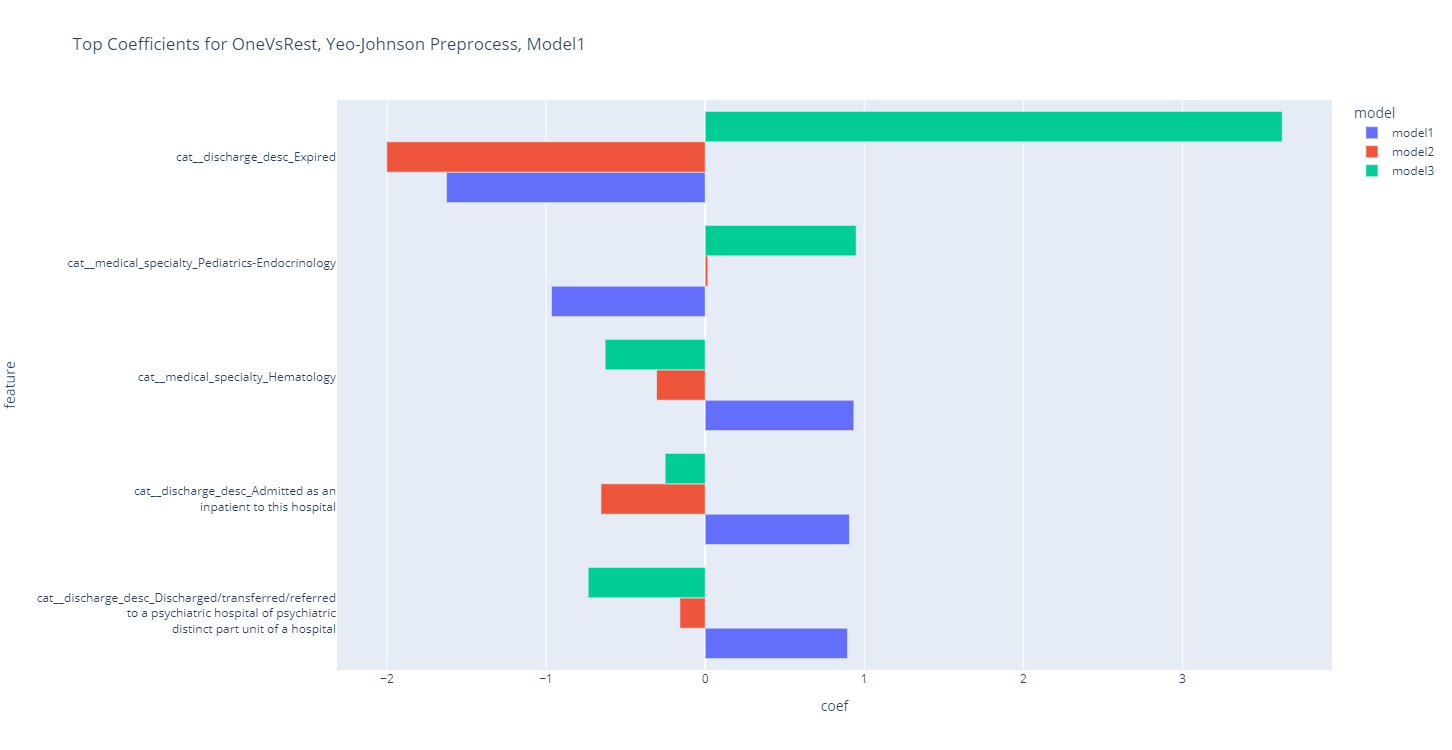

In [80]:
m1_top10_df = create_topn_long_coef_df_from_gs(gs=g, topn=5,
                                               sort_model="model1")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Model1"

fig = px.bar(data_frame=m1_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

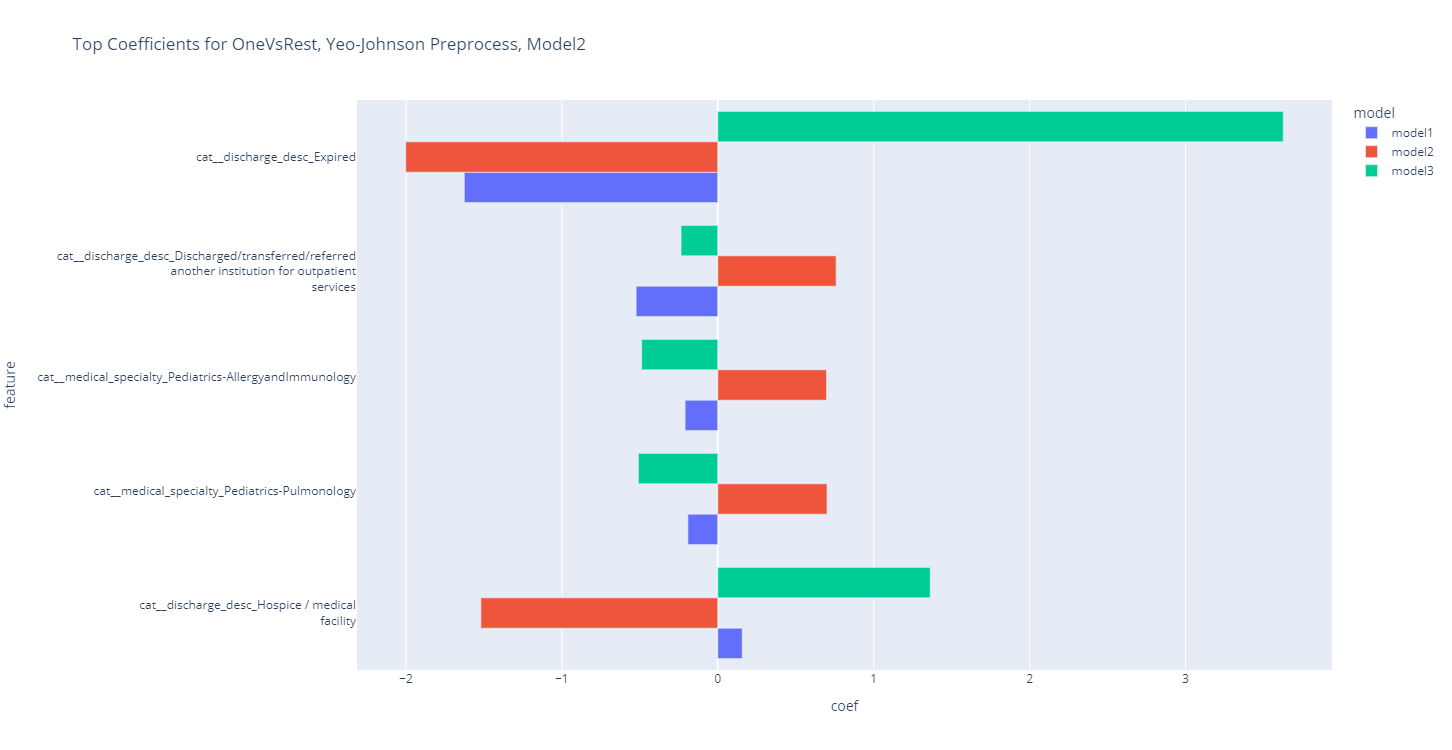

In [81]:
m2_top10_df = create_topn_long_coef_df_from_gs(gs=g, topn=5,
                                               sort_model="model2")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Model2"

fig = px.bar(data_frame=m2_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

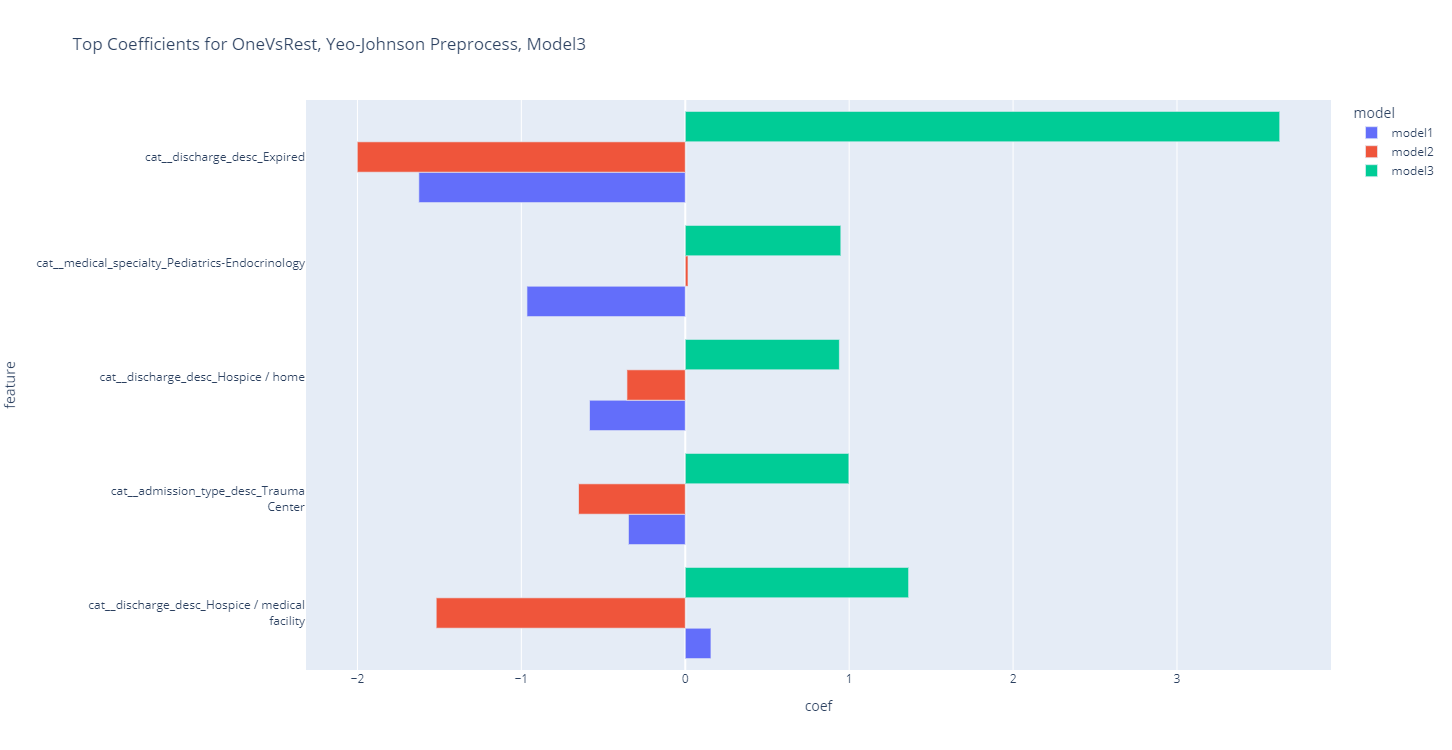

In [82]:
m3_top10_df = create_topn_long_coef_df_from_gs(gs=g, topn=5,
                                               sort_model="model3")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Model3"

fig = px.bar(data_frame=m3_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

### Gridsearch, OneVsRest, StandardScaler

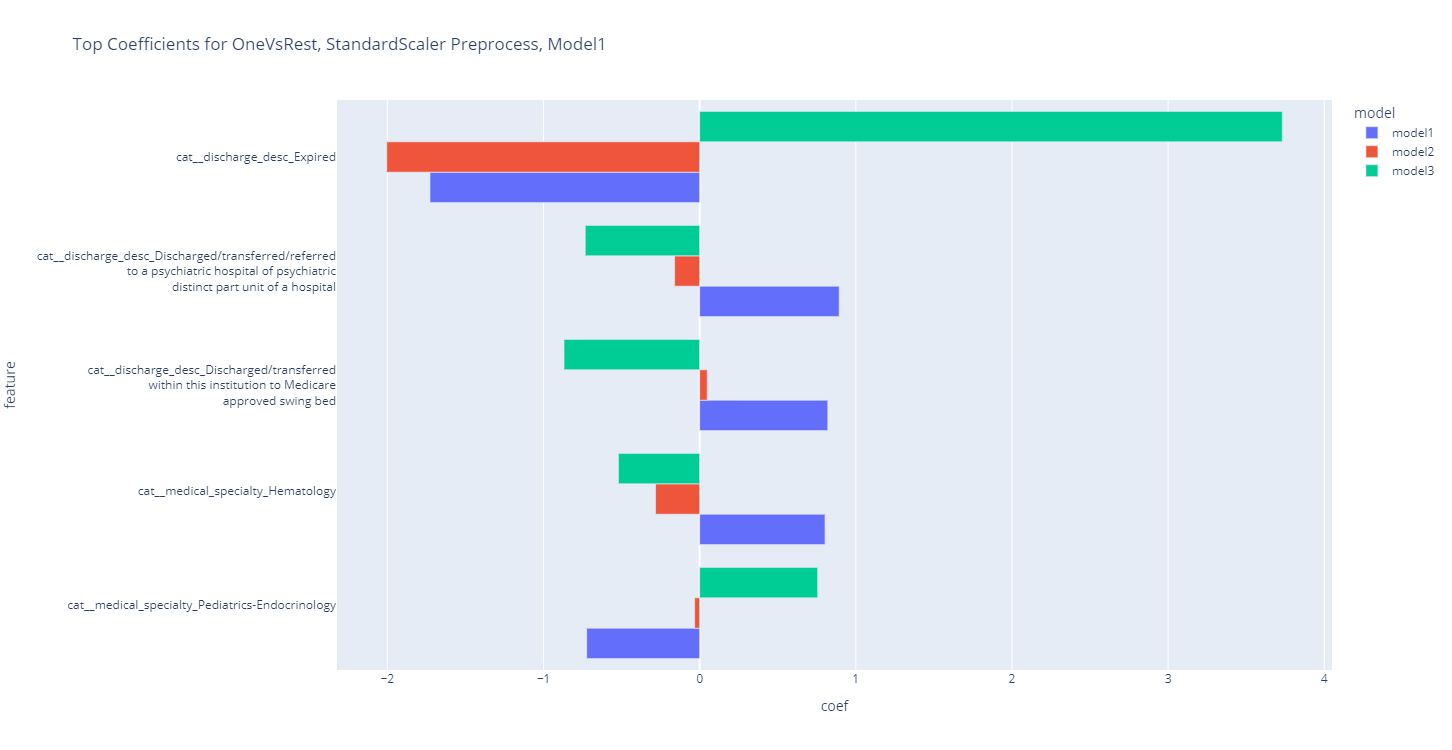

In [83]:
m1_ss_top10_df = create_topn_long_coef_df_from_gs(gs=g_sc, topn=5,
                                                  sort_model="model1")

title = f"Top Coefficients for OneVsRest, StandardScaler Preprocess, Model1"

fig = px.bar(data_frame=m1_ss_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

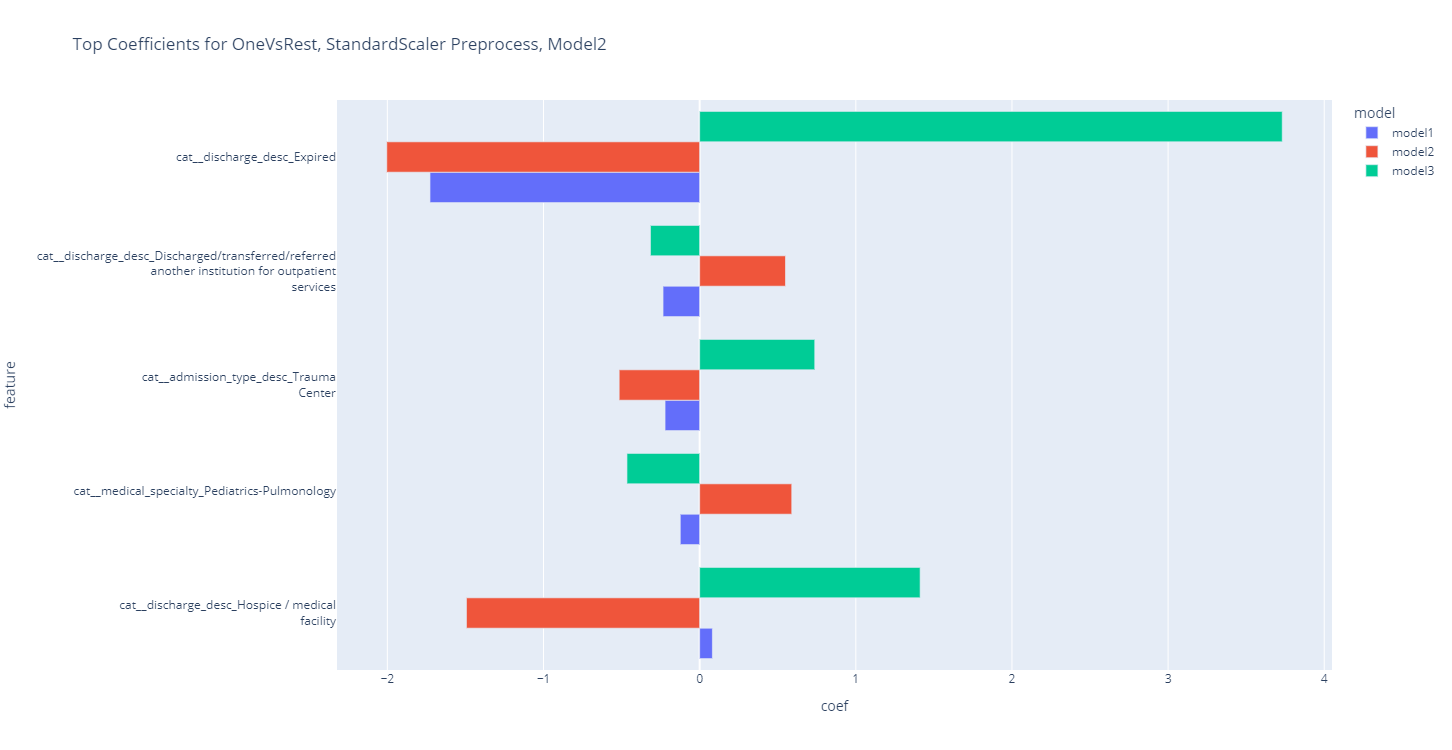

In [84]:
m2_ss_top10_df = create_topn_long_coef_df_from_gs(gs=g_sc, 
                                                  topn=5,
                                                  sort_model="model2")

title = f"Top Coefficients for OneVsRest, StandardScaler Preprocess, Model2"

fig = px.bar(data_frame=m2_ss_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

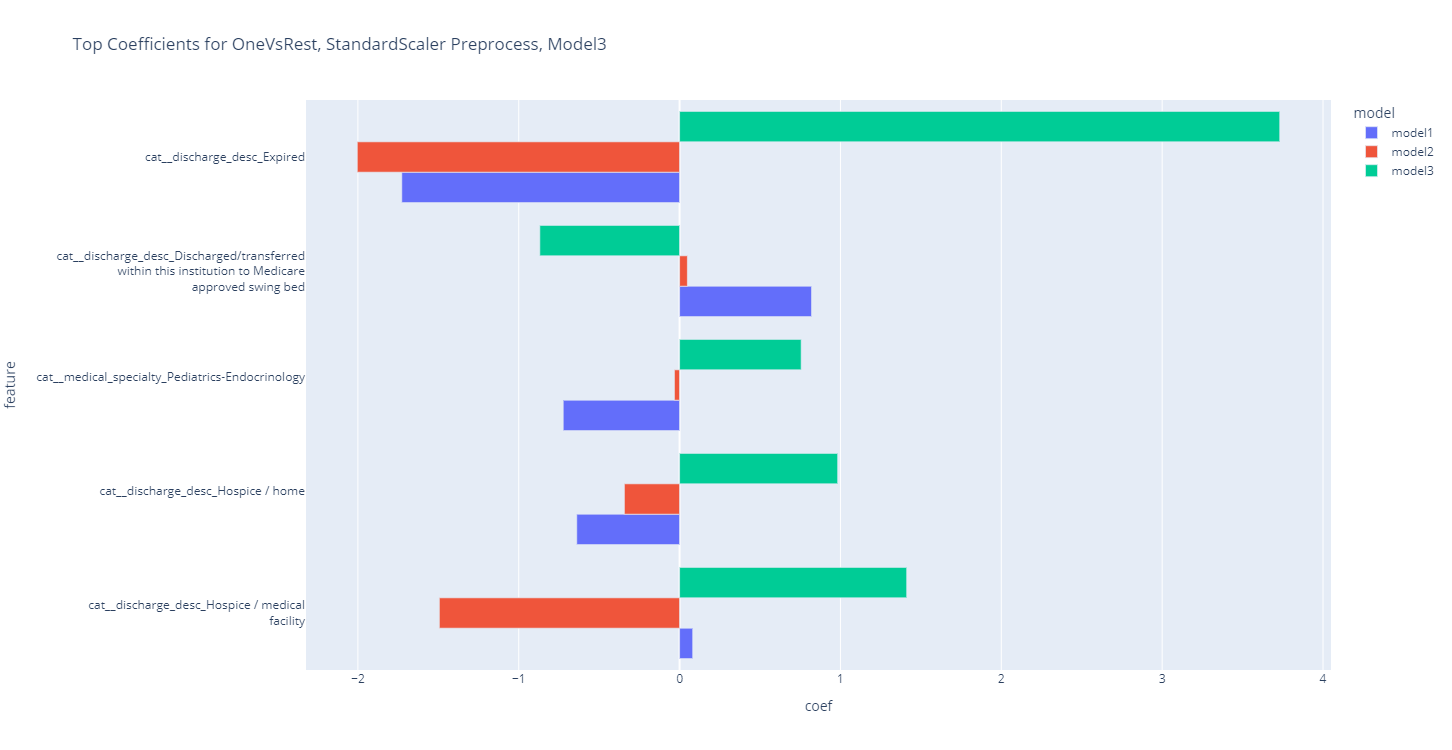

In [85]:
m3_ss_top10_df = create_topn_long_coef_df_from_gs(gs=g_sc, topn=5,
                                                  sort_model="model3")

title = f"Top Coefficients for OneVsRest, StandardScaler Preprocess, Model3"

fig = px.bar(data_frame=m3_ss_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

### Gridsearch, OneVsRest, yeo-johnson, polynomial features

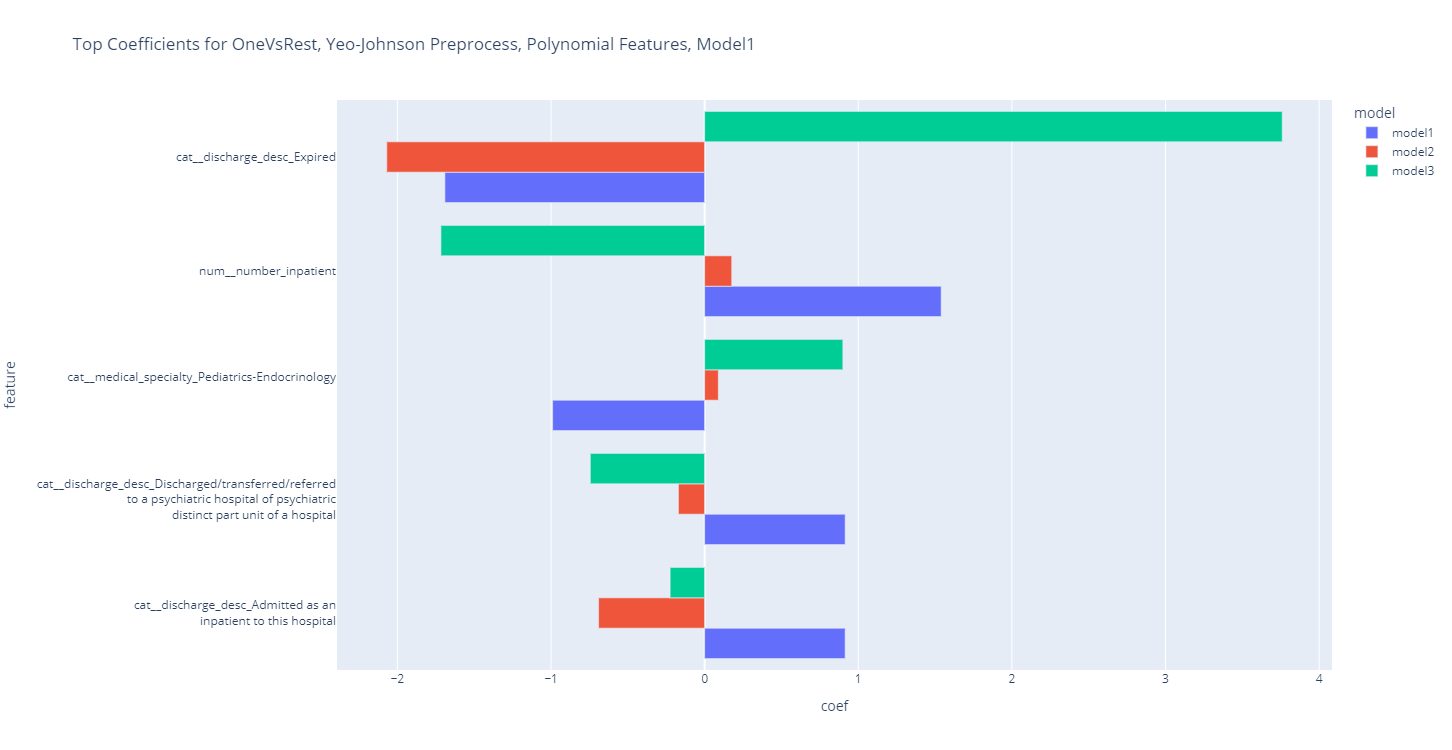

In [86]:
m1_poly_top10_df = create_topn_long_coef_df_from_gs(gs=g_poly, topn=5,
                                                    sort_model="model1")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Polynomial Features, Model1"

fig = px.bar(data_frame=m1_poly_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

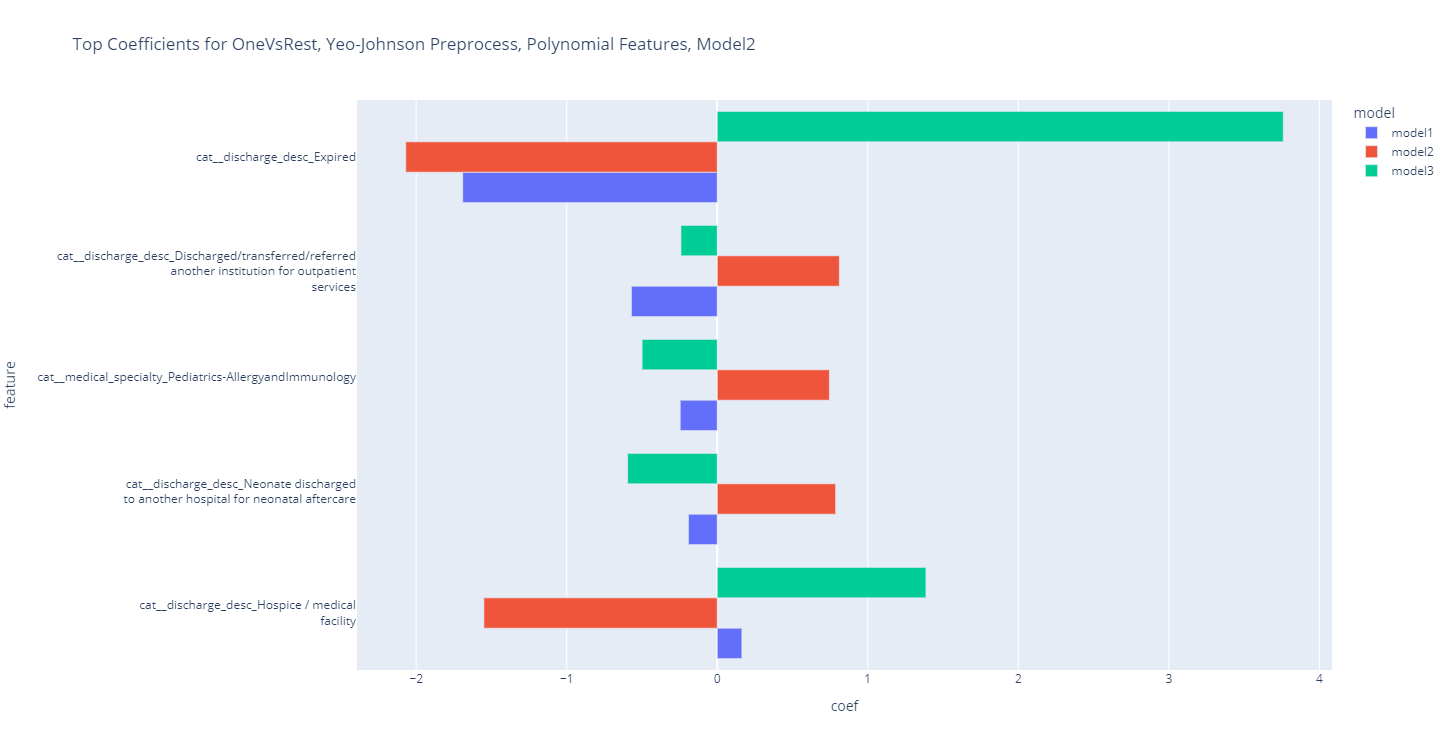

In [87]:
m2_poly_top10_df = create_topn_long_coef_df_from_gs(gs=g_poly, topn=5,
                                                    sort_model="model2")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Polynomial Features, Model2"

fig = px.bar(data_frame=m2_poly_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

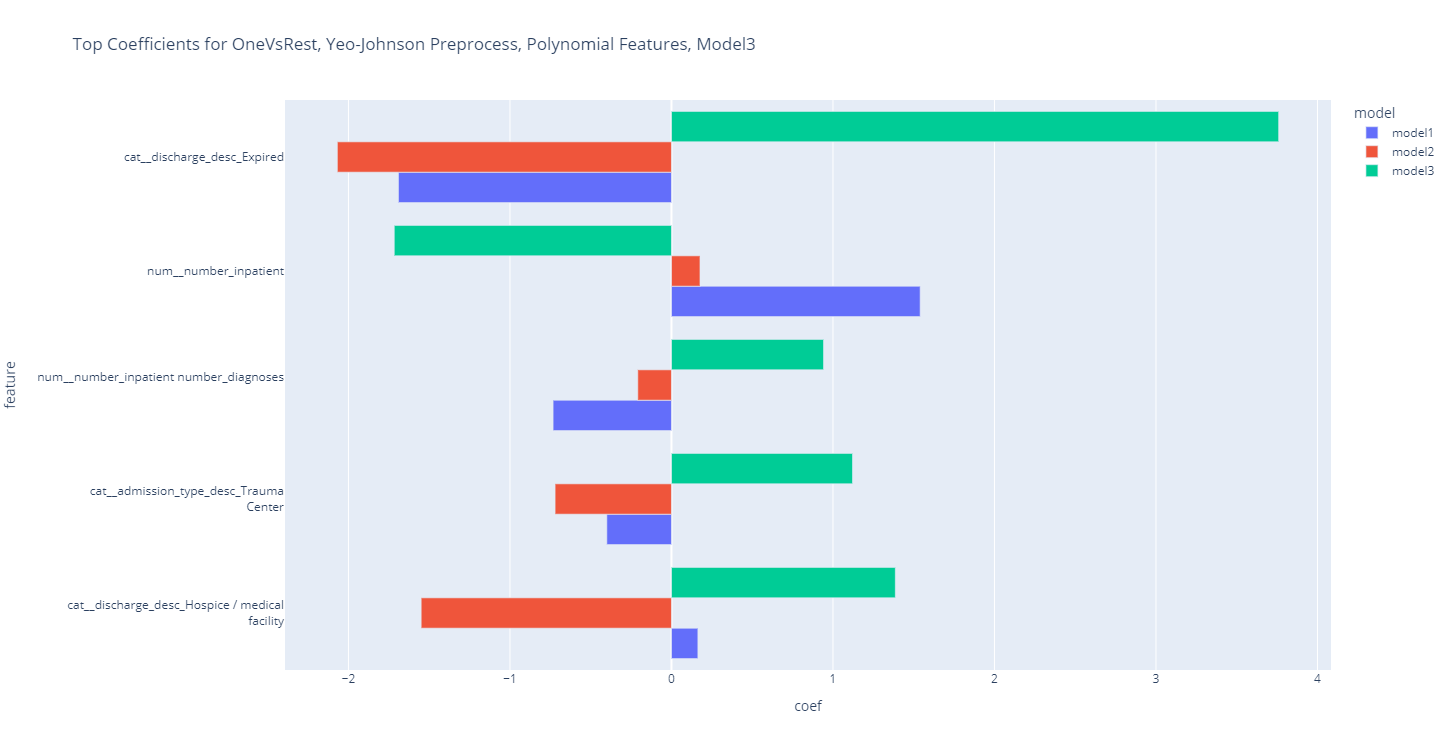

In [88]:
m3_poly_top10_df = create_topn_long_coef_df_from_gs(gs=g_poly, topn=5,
                                                    sort_model="model3")

title = f"Top Coefficients for OneVsRest, Yeo-Johnson Preprocess, Polynomial Features, Model3"

fig = px.bar(data_frame=m3_poly_top10_df, 
             y="feature", 
             x="coef", 
             color="model",
             orientation="h", 
             category_orders={"model":["model1", "model2", "model3"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1250)
fig.show()

# References/Links
- Research paper/data dictionary: https://www.hindawi.com/journals/bmri/2014/781670/
- https://scikit-learn.org/stable/modules/impute.html
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py